In [1]:
# COMP30027 Machine Learning, 2024 Sem 1
# Project 2: IMDB Movie Score Prediction
# Authors:
# Jerrilyn Looi (1342292)
# Melissa Putri (1389438)

In [2]:
import numpy as np
import pandas as pd

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from collections import Counter



In [3]:
# Load and Split Data ===============================================================================
train_data = pd.read_csv("train_dataset.csv")
test_data = pd.read_csv("test_dataset.csv")

y_train = train_data[train_data.columns[-1]]
X_train = train_data.drop(columns=[train_data.columns[-1]])  # "imdb_score_binned" in last column

X_test = test_data

In [4]:
# Loading preprocessed data =========================================================================
actor_1_features = np.load('features_countvec/train_countvec_features_actor_1_name.npy')
actor_2_features = np.load('features_countvec/train_countvec_features_actor_2_name.npy')
director_features = np.load('features_countvec/train_countvec_features_director_name.npy')

genre_features = np.load('features_doc2vec/train_doc2vec_features_genre.npy')
plot_features = np.load('features_doc2vec/train_doc2vec_features_plot_keywords.npy')
title_embeddings = np.load('features_fasttext/train_fasttext_title_embeddings.npy')

# Convert numpy arrays to pandas DataFrames
actor_1_df = pd.DataFrame(actor_1_features, columns=[f'actor_1_feat_{i}' for i in range(actor_1_features.shape[1])])
actor_2_df = pd.DataFrame(actor_2_features, columns=[f'actor_2_feat_{i}' for i in range(actor_2_features.shape[1])])
director_df = pd.DataFrame(director_features, columns=[f'director_feat_{i}' for i in range(director_features.shape[1])])

genre_df = pd.DataFrame(genre_features, columns=[f'genre_feat_{i}' for i in range(genre_features.shape[1])])
plot_df = pd.DataFrame(plot_features, columns=[f'plot_feat_{i}' for i in range(plot_features.shape[1])])
title_embeddings_df = pd.DataFrame(title_embeddings, columns=[f'title_embed_{i}' for i in range(title_embeddings.shape[1])])

X_train = pd.concat([X_train, genre_df, plot_df, title_embeddings_df], axis=1)

In [5]:
# Loading preprocessed data for test ================================================================
actor_1_features = np.load('features_countvec/test_countvec_features_actor_1_name.npy')
actor_2_features = np.load('features_countvec/test_countvec_features_actor_2_name.npy')
director_features = np.load('features_countvec/test_countvec_features_director_name.npy')
genre_features = np.load('features_doc2vec/test_doc2vec_features_genre.npy')
plot_features = np.load('features_doc2vec/test_doc2vec_features_plot_keywords.npy')
title_embeddings = np.load('features_fasttext/test_fasttext_title_embeddings.npy')

# Convert numpy arrays to pandas DataFrames
actor_1_df = pd.DataFrame(actor_1_features, columns=[f'actor_1_feat_{i}' for i in range(actor_1_features.shape[1])])
actor_2_df = pd.DataFrame(actor_2_features, columns=[f'actor_2_feat_{i}' for i in range(actor_2_features.shape[1])])
director_df = pd.DataFrame(director_features, columns=[f'director_feat_{i}' for i in range(director_features.shape[1])])
genre_df = pd.DataFrame(genre_features, columns=[f'genre_feat_{i}' for i in range(genre_features.shape[1])])
plot_df = pd.DataFrame(plot_features, columns=[f'plot_feat_{i}' for i in range(plot_features.shape[1])])
title_embeddings_df = pd.DataFrame(title_embeddings, columns=[f'title_embed_{i}' for i in range(title_embeddings.shape[1])])

X_test = pd.concat([X_test, genre_df, plot_df, title_embeddings_df], axis=1)

In [6]:
# Drop Irrelevant and/or Non-numeric Columns ========================================================

columns_to_drop = ['id','actor_1_name', 'actor_2_name', 'director_name', 'genres', 'plot_keywords', 'movie_title',
                   'actor_3_name', 'title_embedding']

X_train = X_train.drop(columns=columns_to_drop, axis=1)
X_test = X_test.drop(columns=columns_to_drop, axis=1)

# Encode Remaining Categorical Columns ==============================================================

columns_categorical = ['language', 'country', 'content_rating']

encoder = LabelEncoder()
for col in columns_categorical:
  encoder.fit(pd.concat([X_train[col], X_test[col]]))
  X_train[col] = encoder.transform(X_train[col])
  X_test[col] = encoder.transform(X_test[col])
  


In [7]:
# Normalise Data ====================================================================================

numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

#Scaling
standard_scaler = StandardScaler()
standard_scaler.fit(X_train[numeric_cols])
X_train[numeric_cols] = standard_scaler.transform(X_train[numeric_cols])
X_test[numeric_cols] = standard_scaler.transform(X_test[numeric_cols])

In [8]:
# Oversampling
ros = RandomOverSampler(random_state=42)
X_overesampled, y_overesampled = ros.fit_resample(X_train, y_train)

# Undersampling
rus = RandomUnderSampler(random_state=42)
X_underesampled, y_underesampled = rus.fit_resample(X_train, y_train)

# Synthetic Data Generator
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Select Resampling Method
#X_train = X_resampled
#y_train = y_resampled

In [9]:
# Feature Selection =================================================================================
no_feature_selection = X_train

feat_select_model = RandomForestClassifier(n_estimators=100)
feat_select_model.fit(X_train, y_train)

importances = feat_select_model.feature_importances_
feature_names = X_train.columns
sorted_idx = importances.argsort()[::-1]  
features_by_importance = feature_names[sorted_idx]


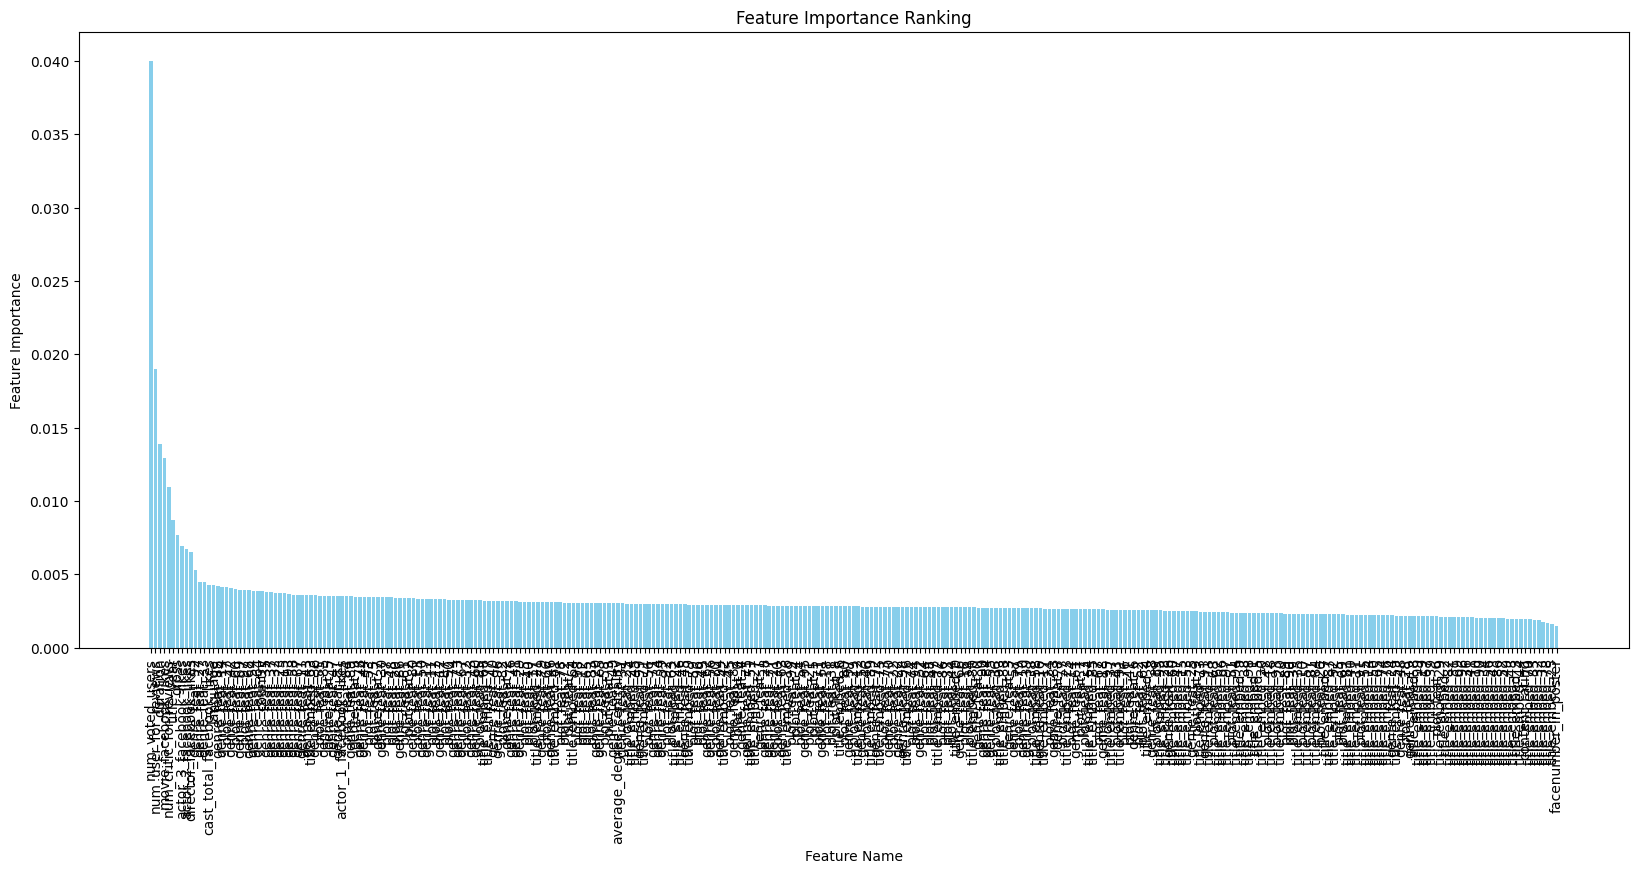

In [10]:
# Plotting Feature Importance =============================================================================

plt.figure(figsize=(20, 8))  # You might need to adjust the figure size for clarity
plt.bar(feature_names[sorted_idx], importances[sorted_idx], color='skyblue')  # You can choose any color
plt.ylabel('Feature Importance')  # Now setting the y-label as Feature Importance
plt.xticks(rotation=90)  # Rotate the feature names for better readability
plt.xlabel('Feature Name')  # X-label is now Feature Name
plt.title('Feature Importance Ranking')
plt.show()

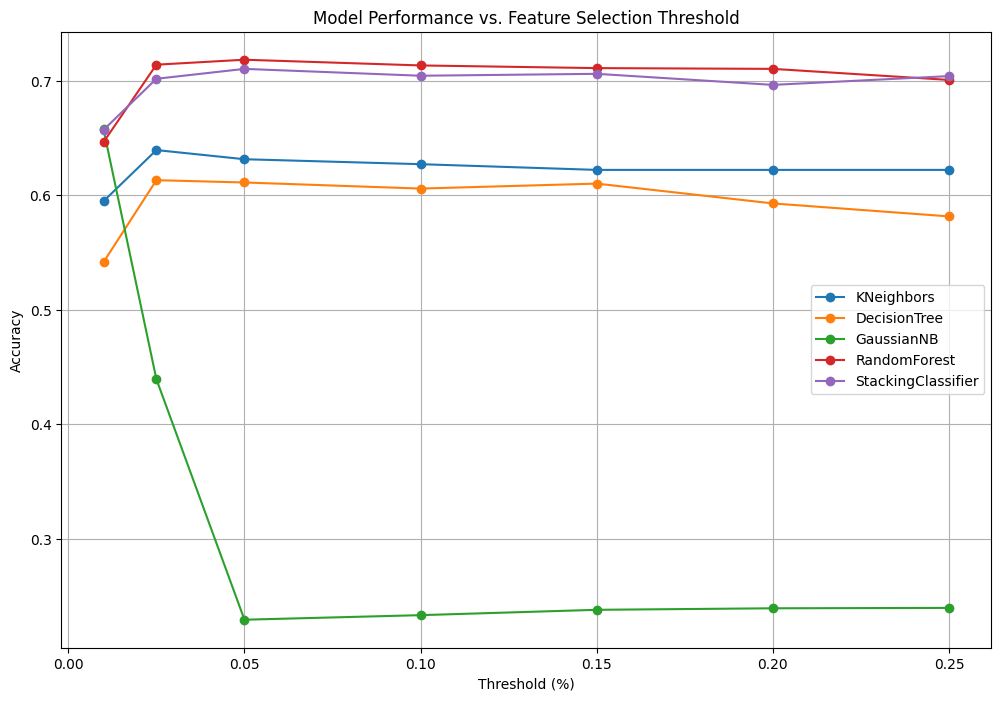

In [11]:
# Plotting Feature Selection Threshold Values ==============================================================================

# Define models to test
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=10)),
    ('knn', KNeighborsClassifier(n_neighbors=3))
]
meta_learner = LogisticRegression()

models = {
    'KNeighbors': KNeighborsClassifier(n_neighbors=3),
    'DecisionTree': DecisionTreeClassifier(),
    'GaussianNB': GaussianNB(),
    'RandomForest': RandomForestClassifier(),
    'StackingClassifier': StackingClassifier(estimators=base_learners, final_estimator=meta_learner, cv=5)
}

# Define thresholds for feature selection
thresholds = [0.01, 0.025, 0.05, 0.1, 0.15, 0.2, 0.25]  # Example threshold values as a percentage of features
model_scores = {name: [] for name in models}  # Dictionary to store scores for each model

# Evaluate each model
for name, model in models.items():
    for thresh in thresholds:
        top_features = features_by_importance[:int(len(features_by_importance) * thresh)]
        X_train_selected = X_train[top_features]
        
        # Fit model on the reduced feature set
        model.fit(X_train_selected, y_train)  # Fit model on selected features for evaluation
        
        # Calculate mean cross-validation score
        score = cross_val_score(model, X_train_selected, y_train, cv=5).mean()
        model_scores[name].append(score)

# Plotting the results
plt.figure(figsize=(12, 8))
for name, scores in model_scores.items():
    plt.plot(thresholds, scores, marker='o', label=name)

plt.xlabel('Threshold (%)')
plt.ylabel('Accuracy')
plt.title('Model Performance vs. Feature Selection Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
# Filter Features According to Selected Threshold Value =========================================

threshold = 0.05
selected_features = features_by_importance[:int(len(features_by_importance) * threshold)]
print(selected_features)

X_train = X_train[selected_features]
X_test = X_test[selected_features]

Index(['num_voted_users', 'num_user_for_reviews', 'duration',
       'movie_facebook_likes', 'num_critic_for_reviews', 'title_year', 'gross',
       'actor_3_facebook_likes', 'actor_2_facebook_likes',
       'director_facebook_likes', 'genre_feat_92', 'genre_feat_27',
       'genre_feat_33', 'cast_total_facebook_likes', 'language'],
      dtype='object')


In [13]:
# Train Models ======================================================================================
model_dict = {}

In [14]:
knn_model = KNeighborsClassifier(n_neighbors=3)
model_dict["knn"] = knn_model
knn_model.fit(X_train, y_train)
knn_accuracy = cross_val_score(knn_model, X_train, y_train, cv=5, scoring='accuracy').mean()
print("KNN Accuracy:", knn_accuracy)

KNN Accuracy: 0.6314914032168608


In [15]:
dt_model = DecisionTreeClassifier()
model_dict["dt"] = dt_model
dt_model.fit(X_train, y_train)
dt_accuracy = cross_val_score(dt_model, X_train, y_train, cv=5, scoring='accuracy').mean()
print("Decision Tree Accuracy:", dt_accuracy)

Decision Tree Accuracy: 0.619508042151969


In [16]:
nb_model = GaussianNB()
model_dict["nb"] = nb_model
nb_model.fit(X_train, y_train)
nb_accuracy = cross_val_score(nb_model, X_train, y_train, cv=5, scoring='accuracy').mean()
print("Naive Bayes Accuracy:", nb_accuracy)

Naive Bayes Accuracy: 0.2293471991125901


In [17]:
weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))

In [18]:
rf_model = RandomForestClassifier(class_weight=class_weights, random_state=42)
model_dict["rf"] = rf_model
rf_model.fit(X_train, y_train)
rf_accuracy = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy').mean()
print("Random Forest Accuracy:", rf_accuracy)

Random Forest Accuracy: 0.7120565723793677


In [19]:

base_learners = [
    ('rf', RandomForestClassifier(n_estimators=10)),
    ('knn', KNeighborsClassifier(n_neighbors=3))
]
meta_learner = LogisticRegression()
stacking_classifier = StackingClassifier(estimators=base_learners, final_estimator=meta_learner, cv=5)
model_dict["sc"] = stacking_classifier
stacking_classifier.fit(X_train, y_train)
stacking_accuracy = cross_val_score(stacking_classifier, X_train, y_train, cv=5, scoring='accuracy').mean()
print("Stacking Accuracy:", stacking_accuracy)

Stacking Accuracy: 0.7107254575707155


In [32]:
# Export CSV Results from test dataset ==============================================================
for model_name, chosen_model in model_dict.items():
    csv_filename = f"_results_{model_name}.csv"
    results = chosen_model.predict(X_test)
    results_df = pd.DataFrame(results, columns=['imbd_score_binned'])
    results_df['id'] = range(1, len(results_df) + 1)
    results_df = results_df[['id', 'imbd_score_binned']]
    results_df.to_csv(csv_filename, index=False, header=True)

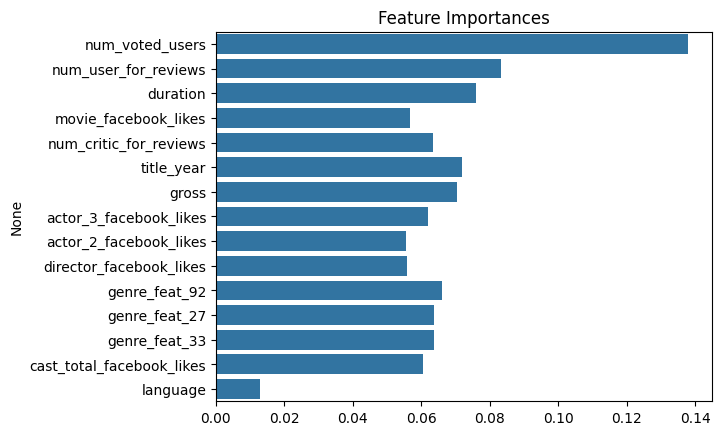

In [21]:
# Plotting  ============================================================================================

# Feature Importance
feature_importances = RandomForestClassifier(n_estimators=100).fit(X_train, y_train).feature_importances_
sns.barplot(x=feature_importances, y=X_train.columns)
plt.title('Feature Importances')
plt.show()

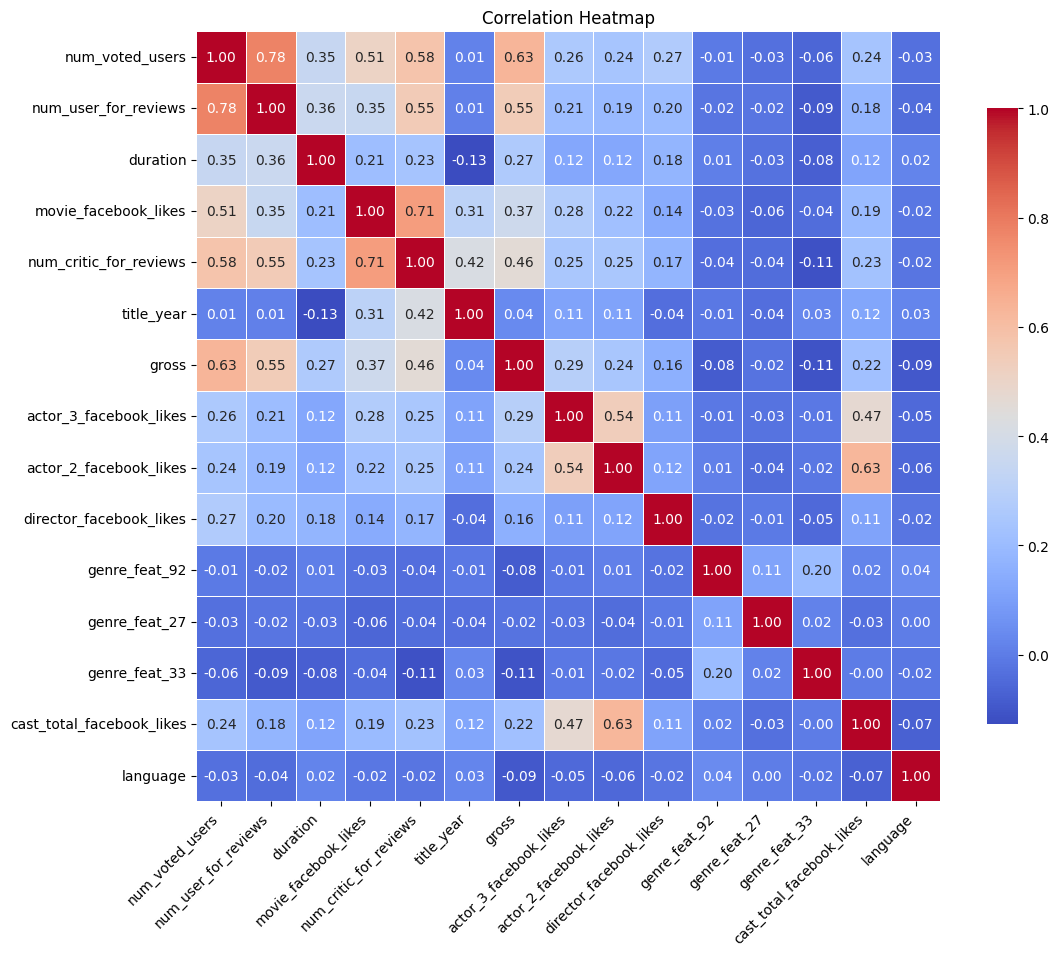

In [22]:
# Correlation Heatmap
# Calculate the correlation matrix
corr = X_train.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=corr.columns, yticklabels=corr.columns,
            linewidths=.5, cbar_kws={"shrink": .8})

# Adjust the layout to make room for the rotation of labels
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Correlation Heatmap')

plt.show()

/var/folders/nb/ptvngvk147s5wfkvdykjdlvm0000gn/T/ipykernel_3740/4126039985.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='imbd_score_binned', data=results_df, palette='viridis')  # You can choose any palette


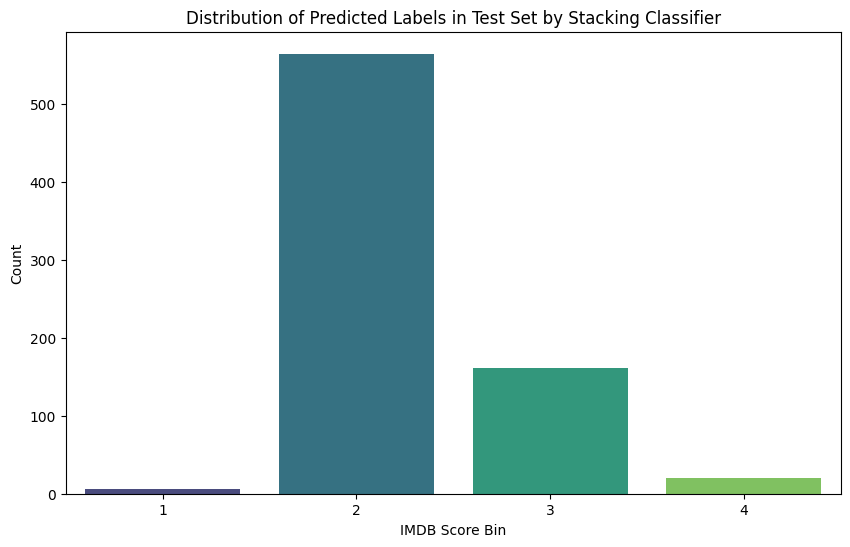

In [23]:
# Plotting Predicted Label Distribution
results = stacking_classifier.predict(X_test)
results_df = pd.DataFrame(results, columns=['imbd_score_binned'])
results_df['id'] = range(1, len(results_df) + 1)

plt.figure(figsize=(10, 6))  # Optional: Adjust the figure size
sns.countplot(x='imbd_score_binned', data=results_df, palette='viridis')  # You can choose any palette
plt.title('Distribution of Predicted Labels in Test Set by Stacking Classifier')
plt.xlabel('IMDB Score Bin')
plt.ylabel('Count')
plt.show()


/var/folders/nb/ptvngvk147s5wfkvdykjdlvm0000gn/T/ipykernel_3740/3532959617.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='imdb_score_binned', data=train_data, palette='viridis')


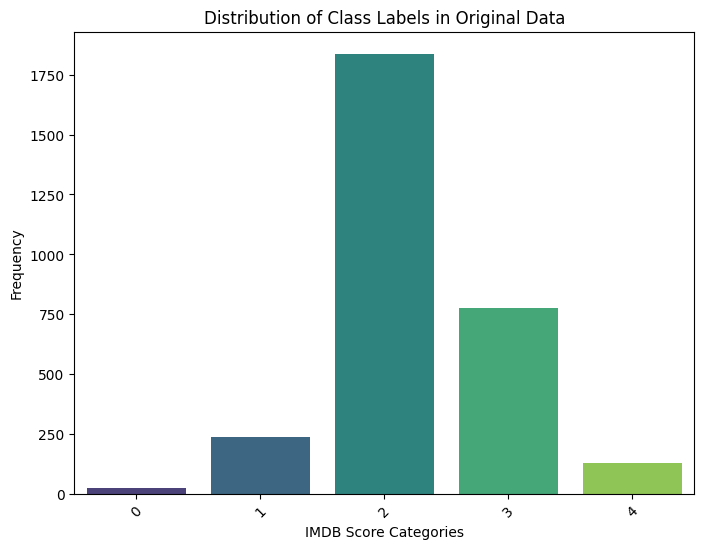

In [24]:
# IMDB Score Distribution

plt.figure(figsize=(8, 6))
sns.countplot(x='imdb_score_binned', data=train_data, palette='viridis')
plt.title('Distribution of Class Labels in Original Data')
plt.xlabel('IMDB Score Categories')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

/var/folders/nb/ptvngvk147s5wfkvdykjdlvm0000gn/T/ipykernel_3740/1077196305.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(dist.keys()), y=list(dist.values()), ax=ax, palette='viridis')
/var/folders/nb/ptvngvk147s5wfkvdykjdlvm0000gn/T/ipykernel_3740/1077196305.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(dist.keys()), y=list(dist.values()), ax=ax, palette='viridis')
/var/folders/nb/ptvngvk147s5wfkvdykjdlvm0000gn/T/ipykernel_3740/1077196305.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(dist.keys()), y=

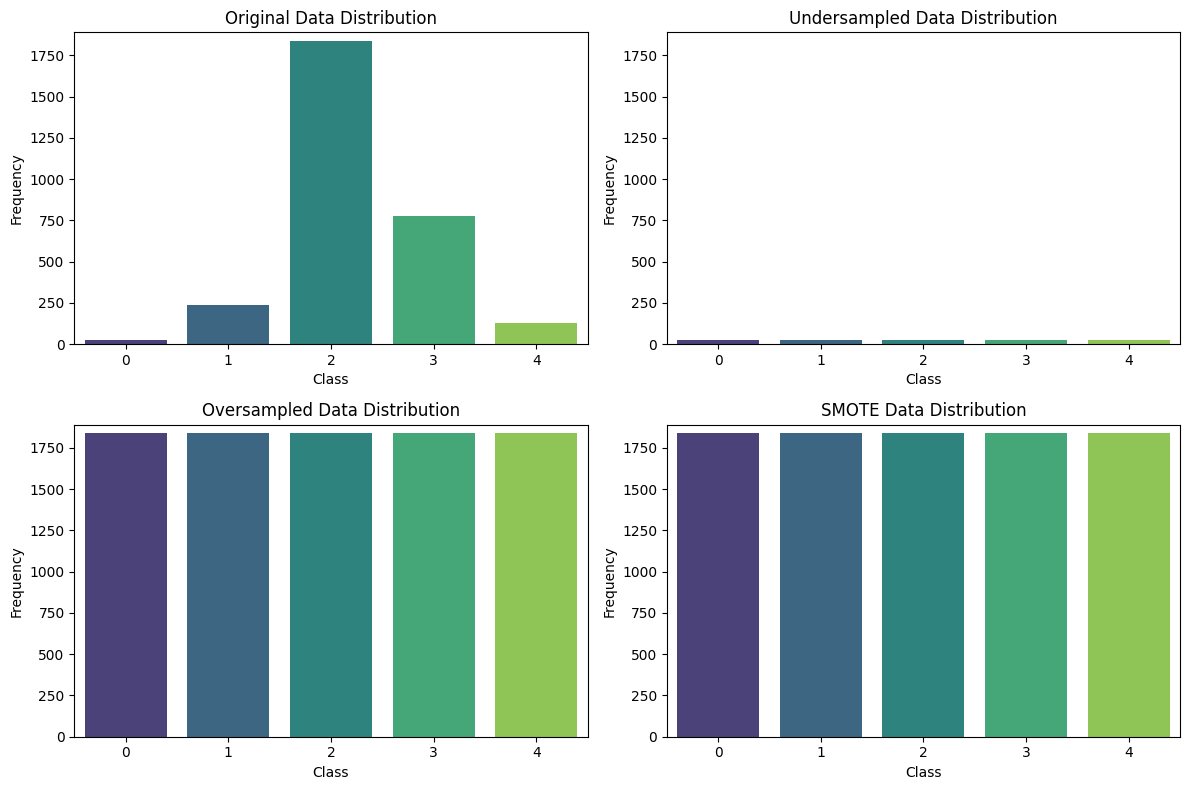

In [25]:
# Comparing class label data distributions

# Data to plot
class_distributions = {
    'Original': Counter(y_train),
    'Undersampled': Counter(y_underesampled),
    'Oversampled': Counter(y_overesampled),
    'SMOTE': Counter(y_resampled)
}

# Set up the matplotlib figure with a 2x2 grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))  # Adjust figsize to fit your display

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each class distribution
for ax, (title, dist) in zip(axes, class_distributions.items()):
    sns.barplot(x=list(dist.keys()), y=list(dist.values()), ax=ax, palette='viridis')
    ax.set_title(f'{title} Data Distribution')
    ax.set_xlabel('Class')
    ax.set_ylabel('Frequency')
    # Set the same y-axis limit for all subplots to ensure they are comparable
    ax.set_ylim(0, max(max(dist.values()) for dist in class_distributions.values()) + 50)

plt.tight_layout()
plt.show()

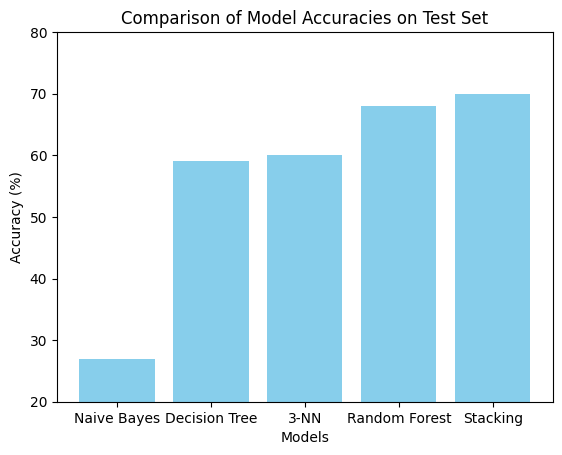

In [26]:
# Accuracy Comparison

models = ['Naive Bayes', 'Decision Tree', '3-NN', 'Random Forest', 'Stacking']
accuracies = [27, 59, 60, 68, 70]

plt.bar(models, accuracies, color='skyblue')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Model Accuracies on Test Set')
plt.ylim([20, 80])
plt.show()

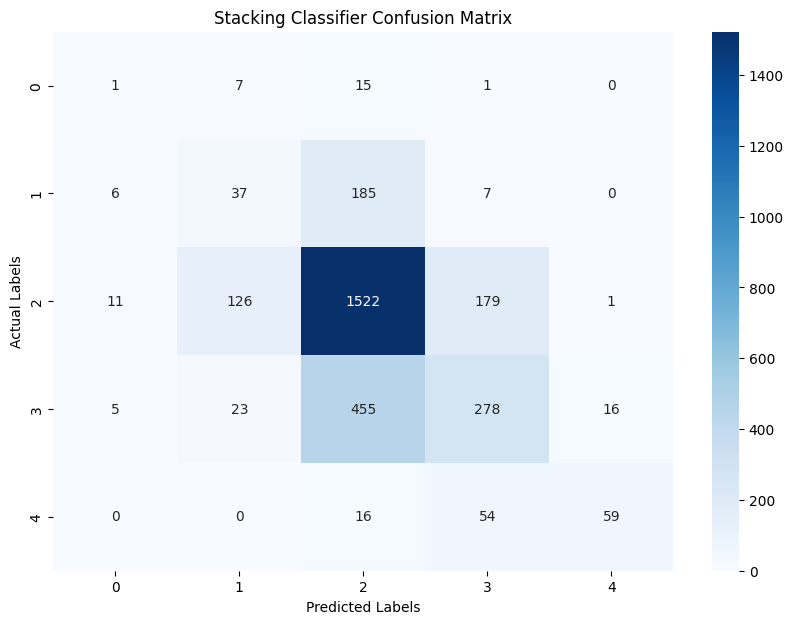

In [27]:
# Confusion Matrix Heatmap

# Generate cross-validated estimates for each input data point
from sklearn.calibration import cross_val_predict


predicted = cross_val_predict(knn_model, X_train, y_train, cv=5)
cm = confusion_matrix(y_train, predicted)

plt.figure(figsize=(10, 7))  # Set the figure size (optional)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')  # 'g' formats numbers as integers
plt.title('Stacking Classifier Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()